## Configuracion

In [1]:
# RECUERDEN SUBIR TODAS LAS IMAGENES QUE USARAN EN UNA CARPETA LLAMADA 'Imagenes'.
# El codigo utiliza cameraman por default, pero pueden usar cualquier imagen que les parezca apropiadas.

from scipy import ndimage
from skimage import filters
from skimage import util
import skimage.io as io

import matplotlib.pyplot as plt
import numpy as np

import os

## Ejemplo de uso de skimage

In [3]:
# Indicamos el camino a la imagen
imagenFilename = os.path.join("./content/Imagenes", 'cameraman.jpg')

# Abrimos la imagen indicando que es en escala de gris
imagenPrueba = io.imread(imagenFilename, as_gray=True)

"""
  Creamos nuestro kernel para convolucionar sobre la imagen con numpy.
  Cada array sera una columna de nuestro kernel, por lo que [[-1,2,-3],[-3,7,3],[-4,5,-6]] sera:

                      | -1 -3 -4 |
                      |  2  7  5 |
                      | -3  3 -6 |

  Recordar que en la convolucion se rota el kernel, por lo que se estaria convolucionando con:

                      | -6  3 -3 |
                      |  5  7  2 |
                      | -4 -3 -1 |
 """
kernelPrueba = np.array([[-1,2,-3],[-3,7,3],[-4,5,-6]], dtype=np.int16)

# Para que no causar errores numericos, asegurense que el tipo de dato del kernel y la imagen coincidan
# En este caso usaremos int de 16 bits con signo porque los numeros del kernel son chicos.
# Y el resultado de la convolucion no deberia pasarse de [-32,767, 32,767]
# Si se pasara habria overflow y la imagen apareceria muy ruidosa
imagenPruebaInt16 = imagenPrueba.astype(np.int16)

#Realizamos la convolucion
imagenConvolucionada = ndimage.convolve(imagenPruebaInt16, kernelPrueba)

# Normalizamos la imagen y la volvemos a setear en el rango [0,255]. Con el rango acotado volvemos a convertirlo en uint8
maximoValor = np.max(imagenConvolucionada)
minimoValor = np.min(imagenConvolucionada)
imagenConvolucionadaNormalizada = np.trunc(((imagenConvolucionada - minimoValor) / maximoValor - minimoValor) * 255).astype(np.uint8)

# Mostramos el resultado final
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

# Usamos imshow para graficar imagenes, utilizando el cmap plt.cm.gray para especificar que esta en escala de grises
ax[0].imshow(imagenPrueba, cmap=plt.cm.gray)
ax[1].imshow(imagenConvolucionada, cmap=plt.cm.gray)

fig.tight_layout()
plt.show()


In [4]:
# Aplicacion de una mascara gausseana utilizando skimage
# Pueden ver mas mascaras de skimage en https://scikit-image.org/docs/stable/api/skimage.filters.html
a = np.zeros((11, 11))
a[5, 5] = 1
ejemplo = filters.gaussian(a, sigma=0.4)
plt.imshow(ejemplo)


# **Deteccion de Borde por Metodo de Gradiante**


## **1)** Implemente los operadores de Roberts, Prewitt y Sobel

### Sobel

In [4]:
def binarizador(img , umbral):
    imagen2 = img
    # si umbral es 0, devuelvo la imagen sin binarizar (sodel comun)
    if (umbral != 0):

        # hago una mascara de los pixeles que estan por arriba del umbral
        # a los que estan por encima les asigno el nivel de gris 255 y a los que no los dejo en 0 
        imagen2 = ((np.ones(img.shape)*umbral)<=img) * 255
        return imagen2
    
    return imagen2


In [5]:
def gradiente(imagen, umbral, matrizdx, matrizdy):
    imagenNorm = imagen/255
    dxconv = ndimage.convolve(imagenNorm,matrizdx)
    dyconv = ndimage.convolve(imagenNorm,matrizdy)
    
    res = np.sqrt(dxconv**2+dyconv**2)
    
    res = binarizador(res, umbral)
    return res

In [6]:
def Sobel(image, thresholdBorde):
  dysobel = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
  #dysobel = dysobel/np.sum(np.abs(dysobel))
  dxsobel = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
  #dxsobel = dxsobel/np.sum(np.abs(dxsobel))
  
  res = gradiente(image,thresholdBorde,dxsobel,dysobel)
  return res

In [7]:
imagenFilename = os.path.join("./content/Imagenes", 'cameraman.jpg')
imagenPrueba = io.imread(imagenFilename, as_gray=True)

imagenBordes = Sobel(imagenPrueba, 0.66)
imagenBordesSkiImg = filters.sobel(imagenPrueba)

fig, axes = plt.subplots(1, 3, figsize=(10, 10))

print(imagenBordes)
print(imagenPrueba)

axes[0].imshow(imagenPrueba, cmap=plt.cm.gray)
axes[1].imshow(imagenBordes, cmap=plt.cm.gray)
axes[2].imshow(imagenBordesSkiImg, cmap=plt.cm.gray)

fig.tight_layout()
plt.show()


### Prewitt

In [8]:
def Prewitt(image, thresholdBorde):
  dxprewitt = np.array([[-1,-1,-1],[0,0,0],[1,1,1]])
  dyprewitt = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
  
  res = gradiente(image,thresholdBorde,dxprewitt,dyprewitt)

  return res

In [9]:
imagenFilename = os.path.join("./content/Imagenes", 'cameraman.jpg')
imagenPrueba = io.imread(imagenFilename, as_gray=True)

imagenBordes = Prewitt(imagenPrueba, 0)
imagenBordesSkiImg = filters.prewitt(imagenPrueba)

fig, axes = plt.subplots(1, 3, figsize=(10, 10))

axes[0].imshow(imagenPrueba, cmap=plt.cm.gray)
axes[1].imshow(imagenBordes, cmap=plt.cm.gray)
axes[2].imshow(imagenBordesSkiImg, cmap=plt.cm.gray)

fig.tight_layout()
plt.show()

### Roberts

In [10]:
def Roberts(image, thresholdBorde):
  dxroberts = np.array([[0,1],[-1,0]])
  dyroberts = np.array([[1,0],[0,-1]])
  
  res = gradiente(image,thresholdBorde,dxroberts,dyroberts)

  return res

In [11]:
imagenFilename = os.path.join("./content/Imagenes", 'cameraman.jpg')
imagenPrueba = io.imread(imagenFilename, as_gray=True)

imagenBordes = Roberts(imagenPrueba, 0)
imagenBordesSkiImg = filters.roberts(imagenPrueba)

fig, axes = plt.subplots(1, 3, figsize=(10, 10))

axes[0].imshow(imagenPrueba, cmap=plt.cm.gray)
axes[1].imshow(imagenBordes, cmap=plt.cm.gray)
axes[2].imshow(imagenBordesSkiImg, cmap=plt.cm.gray)

fig.tight_layout()
plt.show()

# **Metodo Laplaciano**

Implementen el metodo de deteccion de bordes utilizando el operador Laplaciano con y sin chequeo de la varianza total

In [2]:
#Zero crossing con barrido horizontal
def zerocrossing(imagen):
    imagenSigno = np.sign(imagen)
    res = np.zeros(imagen.shape)
    for i in range(imagenSigno.shape[0]):
        for j in range(imagenSigno.shape[1]):
            if (i != 0 ):
                if(imagenSigno[i-1,j] != imagenSigno[i,j]):
                    res[i,j] = 1
    return res

In [3]:
def LaplacianoSinVarianzaLocal(imagen):
  imagenNorm = imagen
  
  #Se obtiene la imagen resultante de aplicar la mascara del laplaciano
  laplaciano = np.array([[0,1,0],[1,-4,1],[0,1,0]])
  matrizL = ndimage.convolve(imagenNorm, laplaciano)
  
  Z = np.zeros(imagenNorm.shape)  
  #Recuperamos los cruces por 0 de la matriz de derivadas segundas  
  matrizZC = zerocrossing(matrizL)
  U = np.ones(imagenNorm.shape)  
  res = 255 * matrizZC 
  return res

Usualmente puede haber artefactos por causa de ruido que aparecen como bordes en la imagen resultante luego del operador Laplaciano, consecuencia de ser muy fragil contra el ruido agregado a la imagen original.

Por esta misma razon agregamos un paso mas a nuestro filtro, al realizar zero crossing tambien chequearemos la varianza local del pixel en la imagen original, ya que un punto de borde deberia encontrarse en posiciones de gran variabilidad.

In [5]:
def LaplacianoConVarianzaLocal(imagen, umbralVar):
  imagenNorm = imagen
  filtromed = np.array([[1,1,1],[1,1,1],[1,1,1]])/9
  medias = ndimage.convolve(imagenNorm, filtromed)
  
  
  n = imagenNorm.shape[0]
  m = imagenNorm.shape[1]
  rango = np.arange(-1,1)
  varianza = np.zeros(imagenNorm.shape)
  
  #Se calcula la varianza local aproximada
  for u in range(n):
    for v in range(m):
      suma = 0
      for i in rango:
        for j in rango:
          val = (imagenNorm[u,v]-medias[u+i,v+j])**2
          suma += val
      varianza[u,v] = suma / 9

  #Se obtiene la imagen resultante de aplicar la mascara del laplaciano
  laplaciano = np.array([[0,1,0],[1,-4,1],[0,1,0]])
  matrizL = ndimage.convolve(imagenNorm, laplaciano)  
  
  Zeros = np.zeros(imagenNorm.shape)    
  Unos = np.ones(imagenNorm.shape)
  #Se obtiene la matriz de Zero-Crossing   
  matrizZC = zerocrossing(matrizL)           

  #varFiltrada tiene 1 en los pixeles homologos de la imagen donde la varianza local es mayor al umbral, 0 en los que no
  varFiltrada = varianza > umbralVar
  
  res = Unos * 255 * matrizZC  * varFiltrada
  return res

Prueba con cameraman

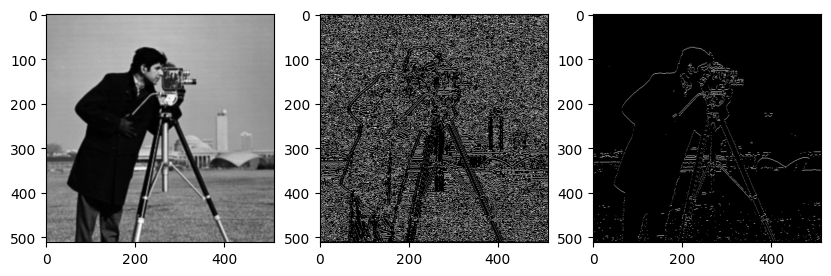

In [49]:
imagenFilename = os.path.join("./content/Imagenes", 'cameraman.jpg')

imagenPrueba = io.imread(imagenFilename, as_gray=True)
imagenPrueba = filters.gaussian(imagenPrueba)

imagenSinVar = LaplacianoSinVarianzaLocal(imagenPrueba)
imagenConVar = LaplacianoConVarianzaLocal(imagenPrueba,0.0005)

imagenLaplace= filters.laplace(imagenPrueba)
fig, axes = plt.subplots(1, 3, figsize=(10, 10))

axes[0].imshow(imagenPrueba, cmap=plt.cm.gray)
axes[1].imshow(imagenSinVar, cmap=plt.cm.gray)
axes[2].imshow(imagenConVar, cmap=plt.cm.gray)

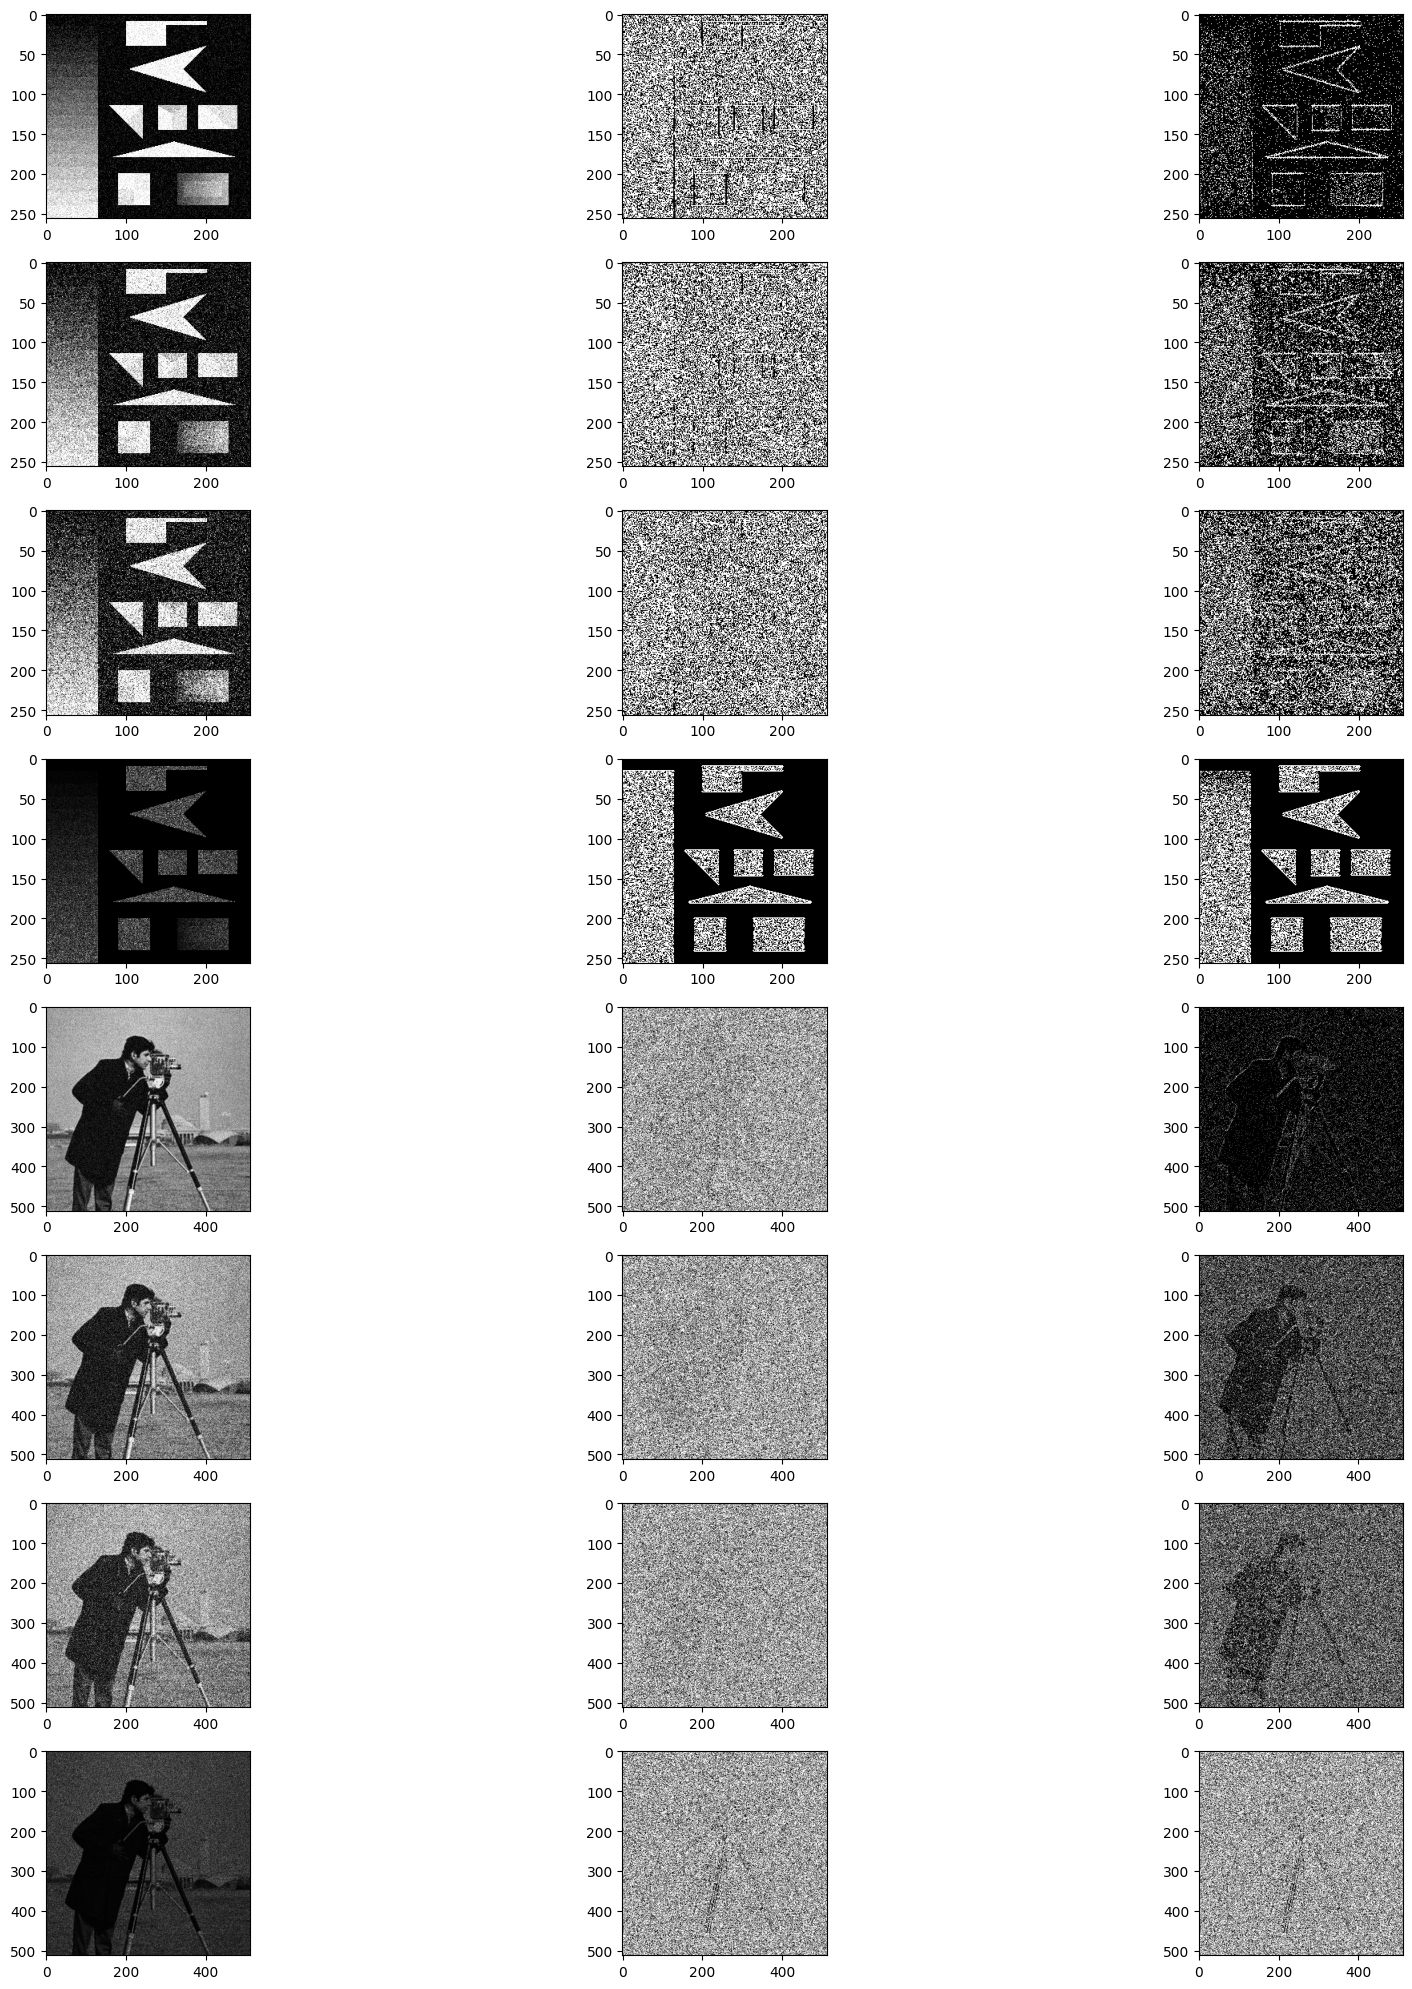

In [32]:
imagenlena = os.path.join("./content/Imagenes", 'cameraman.jpg')
imagenlena = io.imread(imagenlena, as_gray=True)
imagentest = os.path.join("./content/Imagenes", 'test.png')
imagentest = io.imread(imagentest, as_gray=True)

#ACA SE FILTRA IMAGENLENA CON EL RUIDO
#ACA SE FILTRA IMAGENTEST CON EL RUIDO

sigmas = np.array([0.01,0.05,0.1])
lenas = []
tests = []
for sm in sigmas:
    ll = []
    lt = []
    imagen1 = util.random_noise(imagenlena, mode='gaussian', mean=0, var=sm)
    ll.append(imagen1)
    ll.append(LaplacianoSinVarianzaLocal(imagen1))
    ll.append(LaplacianoConVarianzaLocal(imagen1,0.0109))
    lenas.append(ll)

    imagen2 = util.random_noise(imagentest, mode='gaussian', mean=0, var=sm)
    lt.append(imagen2)
    lt.append(LaplacianoSinVarianzaLocal(imagen2))
    lt.append(LaplacianoConVarianzaLocal(imagen2,0.005))
    tests.append(lt)

    
#Se añade rayleigh
ll = []
lt = []
imagen1 = imagenlena * np.random.rayleigh(0.2, imagenlena.shape)
ll.append(imagen1)
ll.append(LaplacianoSinVarianzaLocal(imagen1))
ll.append(LaplacianoConVarianzaLocal(imagen1,0.005))
lenas.append(ll)

imagen2 = imagentest * np.random.rayleigh(0.2, imagentest.shape)
lt.append(imagen2)
lt.append(LaplacianoSinVarianzaLocal(imagen2))
lt.append(LaplacianoConVarianzaLocal(imagen2,1))
tests.append(lt)

fig, axes = plt.subplots(len(lenas) + len(tests) , 3, figsize=(20, 20))
res = tests + lenas
i=0
while (i<len(lenas) + len(tests) ):
    axes[i,0].imshow(res[i][0], cmap=plt.cm.gray)
    axes[i,1].imshow(res[i][1], cmap=plt.cm.gray)
    axes[i,2].imshow(res[i][2], cmap=plt.cm.gray)
    i = i+1



fig.tight_layout()
plt.show()

## Ruidos

El ruido es una señal no deseada que se mezcla con una señal útil en cualquier sistema de comunicación o proceso. En procesamiento de imagenes nos enfocaremos pricipalmente en ruido Gausseano y Rayleigh, los dos causados por los sensores utilizados en la obtencion de imagenes y con una funcion de probabilida clara.

### Ruido Gausseano

formulaGausseana2D.png

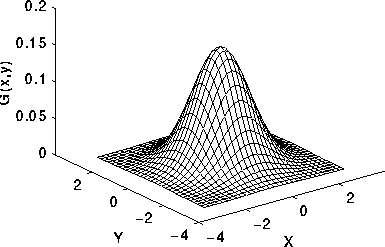

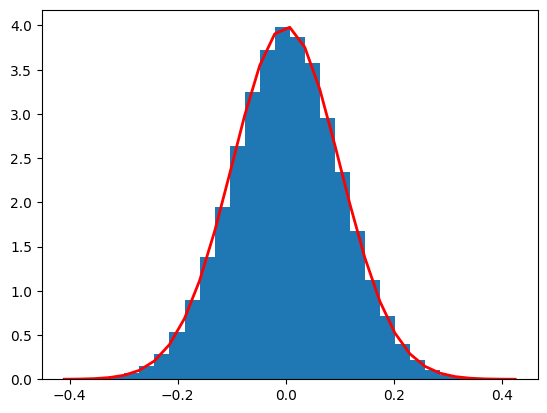

In [24]:
mu, sigma = 0, 0.1
s = np.random.normal(mu, sigma, 100000)

count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.show()

### Ruido Rayleigh

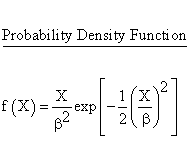


image.png

In [25]:
plt.hist(np.random.rayleigh(1, 100000), bins=200, density=True)
plt.show()

## Ruido y el operador Laplaciano

Comparen que sucede con los bordes detectados segun la cantidad y el tipo de ruidos que se encuentra en la imagen. ¿Por que creen que sucenden estos cambios?

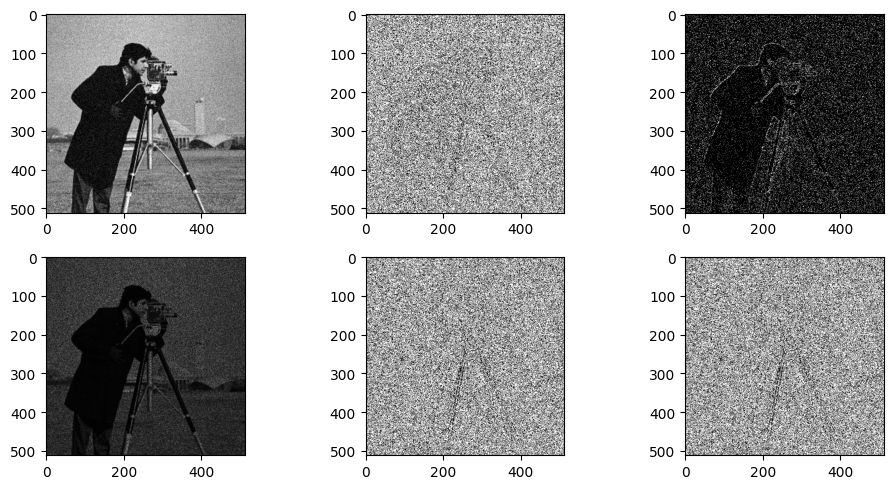

In [46]:
imagenFilename = os.path.join("./content/Imagenes", 'cameraman.jpg')
imagenPrueba = io.imread(imagenFilename, as_gray=True)

# Agregamos ruido Gausseano Aditivo
ImagenConRuidoGausseano = util.random_noise(imagenPrueba, mode='gaussian', mean=0, var=0.01)

#Agregamos ruido Rayleigh Multiplicativo
imagenConRayleigh =  imagenPrueba * np.random.rayleigh(0.2, imagenPrueba.shape)

# Aunque ya no estamos trabajando con imagenes del rango [0,255], nuestros metodos seguiran funcionando
# Ya que todas nuestras tecnicas son generales sobre cualquier señal de 2 dimensiones.

fig, axes = plt.subplots(2, 3, figsize=(10, 5))

axes[0][0].imshow(ImagenConRuidoGausseano, cmap=plt.cm.gray)
axes[0][1].imshow(LaplacianoSinVarianzaLocal(ImagenConRuidoGausseano), cmap=plt.cm.gray)
axes[0][2].imshow(LaplacianoConVarianzaLocal(ImagenConRuidoGausseano,0.008), cmap=plt.cm.gray)

axes[1][0].imshow(imagenConRayleigh, cmap=plt.cm.gray)
axes[1][1].imshow(LaplacianoSinVarianzaLocal(imagenConRayleigh), cmap=plt.cm.gray)
axes[1][2].imshow(LaplacianoConVarianzaLocal(imagenConRayleigh,0.008), cmap=plt.cm.gray)

fig.tight_layout()
plt.show()

# **Realce de Bordes**

### Implementar un realce de bordes utilizando Unsharp Masking

In [ ]:

def SharpImage(image,alpha,sigma):

  blur = filters.gaussian(image,sigma)

  M = image - blur
  imgNitida = image + alpha * M

  return imgNitida

# Filtros de ruido

In [ ]:
def agregarRuidoGaussiano(image,mean,var):
    gaussNoise = np.random.normal(mean,var**0.5,image.shape)
    normalizedImage = image/255

    noisyImage = normalizedImage + gaussNoise
    
    return noisyImage

def agregarRuidoRayleigh(image,epsilon):
    rayleighNoise = np.random.rayleigh(epsilon,image.shape)
    normalizedImage = image/255

    noisyImage = normalizedImage * rayleighNoise
    return noisyImage

def agregarSaltNPepper(image,amount):
    uniforme = np.random.uniform(0,1,image.shape)

    pepperP = amount/2
    saltP = amount/2
    normalizedImage = image/255

    normalizedImage[uniforme < pepperP] = 0 
    #plt.matshow(normalizedImage,cmap=plt.cm.gray)

    normalizedImage[uniforme > (1-saltP)] = 1
    #plt.matshow(normalizedImage,cmap=plt.cm.gray)

    return normalizedImage


### Vean como evoluciona la imagen luego de varias operaciones de Sharpening. Hagan el experimento agregando Ruido Gausseana, Rayleigh y Salt and Pepper

In [ ]:
aplicacionesSucesivas = 4

imagenFilename = os.path.join("/content/Imagenes", 'cameraman.jpg')
imagenPrueba = io.imread(imagenFilename, as_gray=True)

# Agregamos ruido Gausseano Aditivo
ImagenConRuidoGausseano = util.random_noise(imagenPrueba, mode='gaussian', mean=0, var=0.01)
#Agregamos ruido Rayleigh Multiplicativo
imagenConRayleigh =  imagenPrueba * np.random.rayleigh(0.2, imagenPrueba.shape)
# Agregamos ruido Gausseano Aditivo
ImagenConSaltAndPepper = util.random_noise(imagenPrueba, mode='s&p', amount=0.3)

fig, axes = plt.subplots(3, aplicacionesSucesivas + 1, figsize=(20, 10))

axes[0][0].imshow(ImagenConRuidoGausseano, cmap=plt.cm.gray)
imagenAAplicar = ImagenConRuidoGausseano
for i in range(aplicacionesSucesivas):
  imagenSharp = SharpImage(imagenAAplicar)
  axes[0][i+1].imshow(imagenSharp, cmap=plt.cm.gray)
  imagenAAplicar = imagenSharp

axes[1][0].imshow(imagenConRayleigh, cmap=plt.cm.gray)
imagenAAplicar = imagenConRayleigh
for i in range(aplicacionesSucesivas):
  imagenSharp = SharpImage(imagenAAplicar)
  axes[1][i+1].imshow(imagenSharp, cmap=plt.cm.gray)
  imagenAAplicar = imagenSharp

axes[2][0].imshow(ImagenConSaltAndPepper, cmap=plt.cm.gray)
imagenAAplicar = ImagenConSaltAndPepper
for i in range(aplicacionesSucesivas):
  imagenSharp = SharpImage(imagenAAplicar)
  axes[2][i+1].imshow(imagenSharp, cmap=plt.cm.gray)
  imagenAAplicar = imagenSharp

fig.tight_layout()
plt.show()


# **Implementacion de Canny**

**Paper Original**: https://www.researchgate.net/publication/224377985_A_Computational_Approach_To_Edge_Detection

**Video Util**: https://www.youtube.com/watch?v=hUC1uoigH6s

Implemente el algoritmo de canny, explique cada una de sus partes y muestre los resultados de forma parecida a la muestra de resultados de un paper, pueden utlizar como referencia el codigo en este collab para mostrar sus resultados. Hagan un analisis cambiando los parametros del filtro Gausseano y comparando los resultados ¿que se esta perdiendo? ¿Por que?

In [2]:
import math
import skimage as ski

In [62]:
def gradiente_canny(imagen, matrizdx, matrizdy):
    imagenNorm = imagen
    # obtenemos los gradientes en ambas direcciones con los operadores de convolución
    dxconv = ndimage.convolve(imagenNorm,matrizdx)
    dyconv = ndimage.convolve(imagenNorm,matrizdy)
    
    # calculamos la magnitud y la orientación del gradiente en cada pixel
    
    magnitud = np.sqrt(dxconv**2+dyconv**2)
    orientacion = np.arctan2(dyconv, dxconv)

    """ for i in res.shape[0]:
            for j in res.shape[1]:
                fy = dyconv[i][j]
                fx = dxconv[i][j]
                
                # obtener orientación del gradiente para el pixel i,j
                if (fx != 0):
                    res = np.array([res[i][j], math.atan(fx/fy)])
                elif (fx > 0):
                    res = np.array([res[i][j], math.pi/2])
                elif (fx < 0):
                    res = np.array([res[i][j], math.pi])
                else:
                    res = np.array([res[i][j], 0]) 

        return res
    """
    return magnitud, orientacion

def supresion_de_no_maximos(grad_mag, grad_orient):
    
    salida = np.zeros(grad_orient.shape)

    # Se clasfica los angulos en 4 regiones: horizontal, vertical, +45 y -45 dependiendo de en que región
    # esté el ángulo del gradiente. Tomamos como 0 al eje horizontal
    
    # ver pagina 731 figura 10.24 a del gonzales (en el libro toma el eje vertical como 0 por eso los ángulos usados son distintos)
    
    # dirección gradiente:  rango ángulo
    
    # vertical:   d0: angulo gradiente entre      (67.5 y 112.5) o (-67.5 y -112.5)
    # -45:          d1: angulo gradiente entre      (-22.5 y -67.5) o (112.5 y 157.5)
    # horizontal:     d2: angulo gradiente entre      (-22.5 y 22.5) o (-157.5 y 157.5)
    # +45:          d1: angulo gradiente entre      (22.5 y 67.5) o (-112.5 y -157.5)
    
    # para simplificar un poco, viendo que la dirección es la misma si vemos solo los angulos positivos podemos 
    # tomar el valor absoluto del angulo y solo comparar para los rangos positivos de cada categoría
    
    # vertical:   d0: angulo gradiente entre      (67.5 y 112.5)
    # -45:          d1: angulo gradiente entre      (112.5 y 157.5)
    # horizontal:     d2: angulo gradiente entre      (0 y 22.5) o (157.5 y 180)
    # +45:          d1: angulo gradiente entre      (22.5 y 67.5)
    
    for i in range(1,grad_orient.shape[0]-1):
        for j in range(1,grad_orient.shape[1]-1):
            pixel_ady1 = 255
            pixel_ady2 = 255
            orientacion = abs(grad_orient[i,j])
            
            # gradiente horizontal, borde vertical: tomo pixeles de arriba y abajo
            if (0 <= orientacion < 22.5 or 157.5 <= orientacion <= 180):
                pixel_ady1 = grad_mag[i, j+1]
                pixel_ady2 = grad_mag[i, j-1]
                
            # gradiente vertical, borde horizontal: tomo pixeles de la izq y der
            if (67.5 <= orientacion < 112.5):
                pixel_ady1 = grad_mag[i+1, j]
                pixel_ady2 = grad_mag[i-1, j]
                
            # gradiente -45, borde +45: tomo pixeles diag arr der y diag abajo izq
            if (112.5 <= orientacion < 157.5):
                pixel_ady1 = grad_mag[i-1, j+1]
                pixel_ady2 = grad_mag[i+1, j-1]
                
            # gradiente +45, borde -45: tomo pixeles diag arr izq y diag abajo der
            if (22.5 <= orientacion < 67.5):
                pixel_ady1 = grad_mag[i-1, j-1]
                pixel_ady2 = grad_mag[i+1, j+1]
            
            
            if (grad_mag[i,j] >= pixel_ady1 and grad_mag[i,j] >= pixel_ady2):
                salida[i,j] = grad_mag[i,j]
            # else salida[i,j] = 0      que está por defecto
             
    return salida

def umbral_por_histeresis(imagen, umbral_MAX, umbral_MIN):

    res = np.zeros(imagen.shape)

    # Nos quedamos con los pixeles por encima de umbral_MAX
    # Descartamos los pixeles por debajo de umbral_MIN
    for i in range(1,imagen.shape[0]):
        for j in range(1,imagen.shape[1]):
            if (imagen[i][j] >= umbral_MAX):
                res[i][j] = 255   
            if (imagen[i][j] < umbral_MIN):
                res[i][j] = 0        
                
    # Procesamos los pixeles entre medio del umbral
    for i in range(1,imagen.shape[0]-1):
        for j in range(1,imagen.shape[1]-1):
            if( imagen[i-1][j-1] >= umbral_MAX or
                imagen[i-1][j] >= umbral_MAX  or
                imagen[i-1][j+1] >= umbral_MAX or
                imagen[i][j+1] >= umbral_MAX or 
                imagen[i][j-1]>= umbral_MAX or 
                imagen[i+1][j-1]>= umbral_MAX or
                imagen[i+1][j]>= umbral_MAX or 
                imagen[i+1][j+1]>= umbral_MAX ):
                res[i][j] = 255
            else:
                res[i][j] = 0

    return res

In [83]:
def canny(imagen, umbral_max, umbral_min):
  # Aplicacion de la mascara Gausseana para reducir el ruido de la imagen y obtener mejores bordes

  gaussian = ski.filters.gaussian(imagen.copy(), 1)
  
  # Adquirir el gradiante de la imagen y el angulo de borde
  # usamos el operador de prewit para aproximar el gradiente
  fx = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
  fy = np.array([[1,0,-1],[1,0,-1],[1,0,-1]])

  magnitud, orientacion = gradiente_canny(gaussian,fx,fy)
  
  # Truncar los angulos de borde de la imagen en 0, 45, 90, 135
  # Aplicar la eliminacion de no maximos, achicando el grosor de los bordes a uno
  suprimido = supresion_de_no_maximos(magnitud, orientacion)

  # aplican histeresis para obtener los bordes finales
  res = umbral_por_histeresis(suprimido, umbral_max, umbral_min)

  return res

In [96]:
# Indicamos el camino a la imagen
imagenFilename = os.path.join("./content/Imagenes", 'einstein.jpg')

# Abrimos la imagen indicando que es en escala de gris
imagenPrueba = io.imread(imagenFilename, as_gray=True)


imagenCanny = canny(imagenPrueba, 0.16, 0.09 )
print(imagenCanny)
# Mostramos el resultado final
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

# Usamos imshow para graficar imagenes, utilizando el cmap plt.cm.gray para especificar que esta en escala de grises
ax[0].imshow(imagenPrueba, cmap=plt.cm.gray)
ax[1].imshow(imagenCanny, cmap=plt.cm.gray)

fig.tight_layout()
plt.show()

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
